In [193]:
import numpy as np
import keras
from keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dense, Flatten
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from keras import regularizers
import csv

In [170]:
train_images = np.load("../train_images.npy")
print(train_images.shape)

(50000, 28, 28)


In [171]:
test_images = np.load("../test_images.npy")
test_images = np.reshape(test_images, (test_images.shape[0], 28, 28, 1))
print(test_images.shape)

(20000, 28, 28, 1)


## Visualize the images

In [172]:
def viewImages(arr):
    for img in arr:
        two_d = (np.reshape(img, (28,28))*255).astype(np.uint8)
        plt.imshow(two_d, cmap='Greys', interpolation='nearest')
        plt.show()
        
def viewImage(img):
    two_d = (np.reshape(img, (28, 28))*255).astype(np.uint8)
    plt.imshow(two_d, cmap='Greys', interpolation='nearest')
    plt.show()

## Preprocessing

In [174]:
# Clean training images to train autoencoder
def find_holes(im, threshold=100):
    kernel = [[1, 1, 1], [1, -8, 1], [1, 1, 1]]
    conv = convolve2d(im, kernel, mode='same')
    max_diff = np.max(conv)
    return np.maximum(0, np.minimum(255, 255 * conv / max_diff)) > threshold
    
def fix_holes(im, holes=None, threshold=100):
    if holes is None:
        holes = find_holes(im, threshold)
        
    kernel = 1/8 * np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    conv = convolve2d(im, kernel, mode='same')
    result = np.array(im)
    result[holes] = conv[holes].flatten()
    return result.flatten()

train_images_clean = np.array([fix_holes(im) for im in train_images])

In [180]:
def preprocess(arr):
    # Reshape images to 28x28x1
    tmp = np.reshape(arr, (arr.shape[0], 28, 28, 1))
    
    # Normalize
    tmp = tmp / 255.0
    
    return tmp

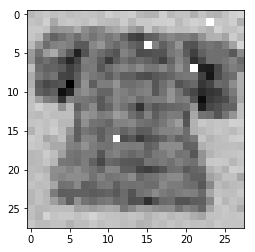

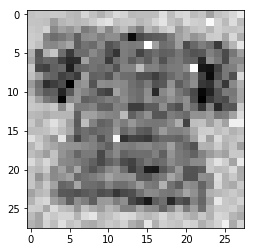

In [181]:
# Normalize data
train_img = preprocess(train_images)
clean_train_img = preprocess(train_images_clean)
test_img = preprocess(test_images)

# Add noise to training data to train autoencoder
noise_factor = 0.07
train_img_noisy = train_img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_img.shape) 
train_img_noisy = np.clip(train_img_noisy, 0., 1.)
viewImages(train_img[:1])
viewImages(train_img_noisy[:1])

## Autoencoder
Understanding Autoencoders Using TensorFlow: https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/

Building Autoencoders in Keras: https://blog.keras.io/building-autoencoders-in-keras.html

Keras Autoencoders: Beginners Tutorial: https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial#denoising_ae

In [122]:
# Encoder
input_img = Input(shape=(28,28,1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

In [162]:
autoencoder.fit(train_images_noisy[:1000], train_images_clean_norm[:1000], epochs=20, validation_data=(train_images_norm[1000:1100], train_images_clean_norm[1000:1100]))

Train on 1000 samples, validate on 100 samples
Epoch 1/20
1000/1000 [==============================] - 67s 67ms/step - loss: 0.6077 - val_loss: 0.6032
Epoch 2/20
1000/1000 [==============================] - 78s 78ms/step - loss: 0.6071 - val_loss: 0.5975
Epoch 3/20
1000/1000 [==============================] - 80s 80ms/step - loss: 0.6048 - val_loss: 0.6068
Epoch 4/20
1000/1000 [==============================] - 84s 84ms/step - loss: 0.6053 - val_loss: 0.5981
Epoch 5/20
1000/1000 [==============================] - 86s 86ms/step - loss: 0.6038 - val_loss: 0.6062
Epoch 6/20
1000/1000 [==============================] - 84s 84ms/step - loss: 0.6053 - val_loss: 0.6083
Epoch 7/20
1000/1000 [==============================] - 85s 85ms/step - loss: 0.6021 - val_loss: 0.5954
Epoch 8/20
1000/1000 [==============================] - 94s 94ms/step - loss: 0.6043 - val_loss: 0.6155
Epoch 9/20
1000/1000 [==============================] - 88s 88ms/step - loss: 0.6019 - val_loss: 0.5963
Epoch 10/20
1000/

In [190]:
x_train = autoencoder.predict(train_img[10000:11000])

In [199]:
x_valid = autoencoder.predict(train_img[11000:12000])

## CNN

In [200]:
with open('../train_labels.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    train_labels = np.array(list(reader))[1:,1]
    
labels = np.zeros((10, 10))
for i in range(10):
    labels[i, i] = 1

train_labels = np.array([labels[int(x), :] for x in train_labels])

y_train = train_labels[10000:11000]
y_valid = train_labels[11000:12000]

In [197]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=5, activation='relu', 
                  input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Flatten())
model.add(Dense(units=10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95),
              metrics=[keras.metrics.BinaryAccuracy()])

In [198]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 46s 46ms/step - loss: 3.0319 - binary_accuracy: 0.9000
Epoch 2/10
1000/1000 [==============================] - 40s 40ms/step - loss: 2.9447 - binary_accuracy: 0.9000
Epoch 3/10
1000/1000 [==============================] - 35s 35ms/step - loss: 2.8355 - binary_accuracy: 0.9000
Epoch 4/10
1000/1000 [==============================] - 38s 38ms/step - loss: 2.6676 - binary_accuracy: 0.9000
Epoch 5/10
1000/1000 [==============================] - 42s 42ms/step - loss: 2.4245 - binary_accuracy: 0.9011
Epoch 6/10
1000/1000 [==============================] - 36s 36ms/step - loss: 2.1821 - binary_accuracy: 0.9056
Epoch 7/10
1000/1000 [==============================] - 48s 48ms/step - loss: 1.9398 - binary_accuracy: 0.9130
Epoch 8/10
1000/1000 [==============================] - 37s 37ms/step - loss: 1.8547 - binary_accuracy: 0.9132
Epoch 9/10
1000/1000 [==============================] - 35s 35ms/step - loss: 1.7057 - binary_accuracy: 0.9202
E

In [201]:
loss_and_metrics = model.evaluate(x_valid, y_valid)
print(loss_and_metrics)

1000/1000 [==============================] - 14s 14ms/step
[1.6886349391937256, 0.9203000664710999]


In [202]:
test_img_clean = autoencoder.predict(test_img)

In [203]:
classes = model.predict(test_img_clean)

In [205]:
classes = classes.argmax(axis=1)

In [206]:
count = 0
with open('submission0.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes):
        writer.writerow([str(idx), str(val)])
        count += 1
        
print(count)

20000


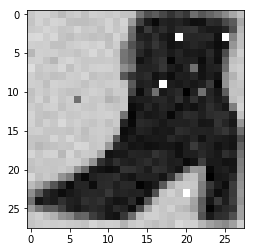

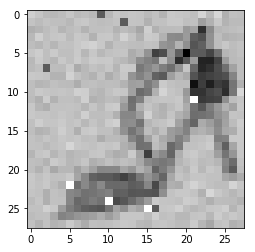

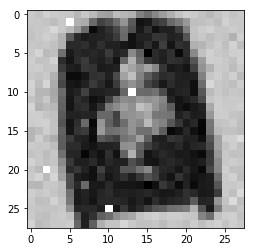

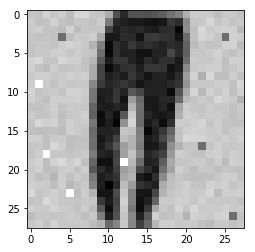

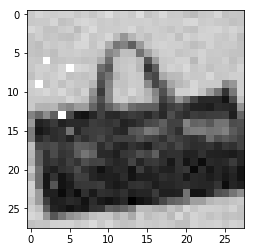

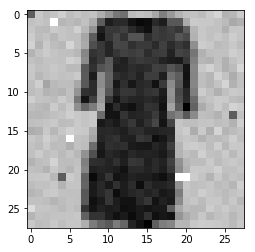

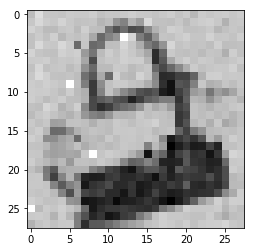

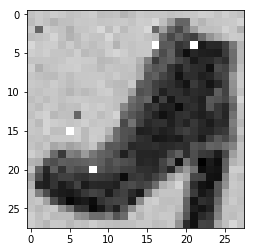

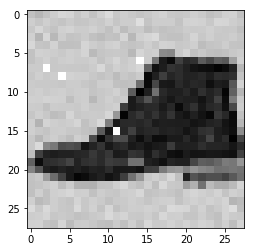

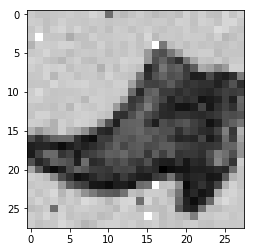

In [207]:
viewImages(test_img[:10])